In [1]:
import sys
import re
import torch
from dataclasses import asdict
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

sys.path.append("../src")
sys.path.append("..")

from quantum_diffusion.data import DatasetLoader

from genQC.dataset.balancing import get_tensor_gate_length  

In [2]:
# Config loading
with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config.yaml")
    cfg = cfg["training"]

In [21]:
# dataset loading
datasets = []
for ds_name in ["srv_3q_dataset", "srv_4q_dataset", "srv_5q_dataset", "srv_6q_dataset", "srv_7q_dataset", "srv_8q_dataset"]:
    dataset_path = f"../datasets/paper_quditkit/{ds_name}"
    # dataset_path = f"../datasets/paper_qiskit/{ds_name}"
    dataset_loader = DatasetLoader(device="cpu", config=cfg)
    dataset = dataset_loader.load_dataset(dataset_path)
    datasets.append(dataset)

[INFO]: Loading tensor from `../datasets/paper_quditkit/srv_3q_dataset/dataset/ds_x.safetensors` onto device: cpu.
[INFO]: Loading tensor from `../datasets/paper_quditkit/srv_3q_dataset/dataset/ds_y.safetensors` onto device: cpu.
[INFO]: Instantiated config_dataset from given config on cpu.
[WARNING]: The value 0 is reserved for background tokens, i.e. qubit time position which are not effected by gates.
[WARNING]: Automatically incrementing all vocabulary values by one ...
[INFO]: `my_genQC.models.frozen_open_clip.CachedFrozenOpenCLIPEmbedder` instantiated from given `config` on cpu.
[INFO]: `my_genQC.models.frozen_open_clip.CachedFrozenOpenCLIPEmbedder`. Found no key `save_type` in `config`. No state dict loaded.
[INFO]: `my_genQC.models.frozen_open_clip.CachedFrozenOpenCLIPEmbedder`. Freeze model: True
2025-12-28 15:10:42 - quantum_diffusion.data.dataset - INFO - Dataset loaded from ../datasets/paper_quditkit/srv_3q_dataset
[INFO]: Loading tensor from `../datasets/paper_quditkit/srv

In [22]:
sample_counts = dict()

for dataset in datasets:
    print(f"========== {dataset.num_of_qubits}q Dataset summary ==========")
    print(f"unique samples: {len(dataset.x)}")
    print(f"min gates: {dataset.min_gates}")
    print(f"max gates: {dataset.max_gates}")
    print(f"gate pool: {dataset.gate_pool}")

    sample_counts[dataset.num_of_qubits] = len(dataset.x)

========== 3q Dataset summary ==========
unique samples: 163327
min gates: 2
max gates: 16
gate pool: ['h', 'cx']
========== 4q Dataset summary ==========
unique samples: 281970
min gates: 3
max gates: 20
gate pool: ['h', 'cx']
========== 5q Dataset summary ==========
unique samples: 497496
min gates: 4
max gates: 28
gate pool: ['h', 'cx']
========== 6q Dataset summary ==========
unique samples: 499926
min gates: 5
max gates: 40
gate pool: ['h', 'cx']
========== 7q Dataset summary ==========
unique samples: 499968
min gates: 6
max gates: 52
gate pool: ['h', 'cx']
========== 8q Dataset summary ==========
unique samples: 599936
min gates: 7
max gates: 52
gate pool: ['h', 'cx']


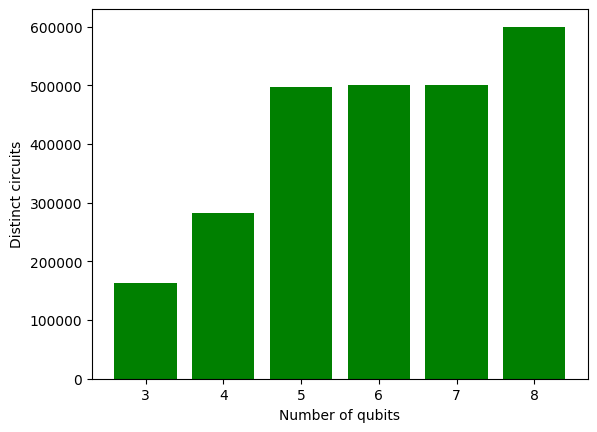

In [23]:
plt.bar(sample_counts.keys(), sample_counts.values(), color="green")

plt.xlabel("Number of qubits")
plt.ylabel("Distinct circuits")

plt.show()

In [24]:
circuit_length_counts = dict()

for dataset in datasets:
    lengths = get_tensor_gate_length(dataset.x, padding_token=0)
    unique_lengths, counts = torch.unique(lengths, return_counts=True)

    for length, count in zip(unique_lengths, counts):
        if int(length) in circuit_length_counts.keys():
            circuit_length_counts[int(length)] += int(count)
        else:
            circuit_length_counts[int(length)] = int(count)

In [15]:
from src.my_genQC.dataset import circuits_dataset

"""
# dataset loading
datasets = []
for ds_name in ["srv_3q_dataset", "srv_4q_dataset", "srv_5q_dataset", "srv_6q_dataset", "srv_7q_dataset", "srv_8q_dataset"]:
    dataset_path = f"../data/paper/{ds_name}"
    dataset_loader = DatasetLoader(device="cpu", config=cfg)
    dataset = dataset_loader.load_dataset(dataset_path)
    datasets.append(dataset)
"""

dataset_loader = DatasetLoader(device="cpu", config=cfg)

mixed_dataset, _ = circuits_dataset.MixedCircuitsConfigDataset.from_datasets(
                                        datasets,
                                        model_scale_factor=4,
                                        balance_maxes=[int(1e8)],
                                        pad_constant=len(datasets[0].gate_pool) + 1,
                                        device="cpu",
                                        bucket_batch_size=-1,
                                        max_samples=[int(1e8)],
                                        **asdict(datasets[0].params_config),
                                        )

  0%|          | 0/6 [00:00<?, ?it/s]

 - balance_tensor_dataset, njobs=1, number of samples=163327
 - uniquify_tensor_dataset, number of samples now 163327
 - balancing


  0%|          | 0/5 [00:00<?, ?it/s]

 - dataset size after balancing 163327
Split: Train 155161 - Test 8166 



<BarContainer object of 13 artists>

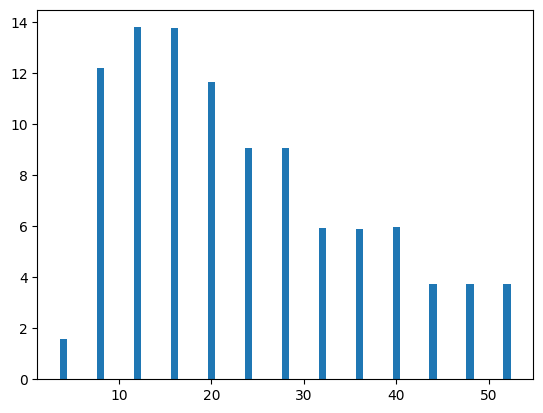

In [25]:
total_samples = sum(count for count in circuit_length_counts.values())
x_axis_vals = []
y_axis_vals = []

current_count = 0
for key, val in circuit_length_counts.items():
    current_count += val
    if int(key)  % 4 == 0:
        x_axis_vals.append(key)
        y_axis_vals.append((current_count / total_samples) * 100)
        current_count = 0
    
plt.bar(x_axis_vals, y_axis_vals, linewidth=1)

In [17]:
srv_pattern = r"(\[.+\])"
srv_counts = dict()

for y in dataset.y:
    search_result = re.search(srv_pattern, y)
    srv = search_result.group(1)
    
    if srv in srv_counts.keys():
        srv_counts[srv] += 1
    else:
        srv_counts[srv] = 1

In [18]:
print("========== SRV summary ==========")
for count in sorted(srv_counts.items()):
    print(f"{count[0]}: {count[1]}")

========== SRV summary ==========
[1, 1, 1, 1, 1, 1, 1, 1]: 79976
[1, 1, 1, 1, 1, 1, 2, 2]: 2896
[1, 1, 1, 1, 1, 2, 1, 2]: 2878
[1, 1, 1, 1, 1, 2, 2, 1]: 2910
[1, 1, 1, 1, 1, 2, 2, 2]: 984
[1, 1, 1, 1, 2, 1, 1, 2]: 2869
[1, 1, 1, 1, 2, 1, 2, 1]: 3005
[1, 1, 1, 1, 2, 1, 2, 2]: 903
[1, 1, 1, 1, 2, 2, 1, 1]: 2867
[1, 1, 1, 1, 2, 2, 1, 2]: 939
[1, 1, 1, 1, 2, 2, 2, 1]: 1012
[1, 1, 1, 1, 2, 2, 2, 2]: 1078
[1, 1, 1, 2, 1, 1, 1, 2]: 2859
[1, 1, 1, 2, 1, 1, 2, 1]: 2944
[1, 1, 1, 2, 1, 1, 2, 2]: 925
[1, 1, 1, 2, 1, 2, 1, 1]: 2912
[1, 1, 1, 2, 1, 2, 1, 2]: 971
[1, 1, 1, 2, 1, 2, 2, 1]: 988
[1, 1, 1, 2, 1, 2, 2, 2]: 1064
[1, 1, 1, 2, 2, 1, 1, 1]: 2876
[1, 1, 1, 2, 2, 1, 1, 2]: 980
[1, 1, 1, 2, 2, 1, 2, 1]: 983
[1, 1, 1, 2, 2, 1, 2, 2]: 1096
[1, 1, 1, 2, 2, 2, 1, 1]: 944
[1, 1, 1, 2, 2, 2, 1, 2]: 1069
[1, 1, 1, 2, 2, 2, 2, 1]: 1078
[1, 1, 1, 2, 2, 2, 2, 2]: 1470
[1, 1, 2, 1, 1, 1, 1, 2]: 2888
[1, 1, 2, 1, 1, 1, 2, 1]: 2941
[1, 1, 2, 1, 1, 1, 2, 2]: 935
[1, 1, 2, 1, 1, 2, 1, 1]: 2838
[1, 1, 2, 1, 1

In [79]:

unique_circuits[0]

tensor([[-2, -2, -2, -2, -2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 2,  0,  2,  0,  2,  0, -2,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  2,  0,  2,  0,  1,  2,  1,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=torch.int32)

In [81]:
unique_circuits[2]

tensor([[-2, -2, -2, -2,  0,  0, -2,  1,  0,  0,  0, -2,  2, -2,  1,  0],
        [ 0,  2,  0,  2,  1,  0,  0,  0, -2,  1,  0,  0, -2,  0,  0,  0],
        [ 2,  0,  2,  0,  0,  1,  2,  0,  2,  0,  1,  2,  0,  2,  0,  0]], dtype=torch.int32)

In [65]:
dataloaders = dataset_loader.get_dataloaders(dataset, batch_size=256, balance_max=5000)

 - balance_tensor_dataset, njobs=1, number of samples=22238
 - uniquify_tensor_dataset, number of samples now 22238
 - balancing


  0%|          | 0/5 [00:00<?, ?it/s]

[INFO]: Generate cache: converting tensors to str and tokenize
 - to str list
 - tokenize_and_push_to_device
 - generate_cache
[INFO]: - `generate_cache` infered a TOKEN limit of 13


  0%|          | 0/1 [00:00<?, ?it/s]

[INFO]: caching trying to allocate memory (6, 77, 512) on cpu, approx. 0.001 GB
[INFO]: Generated cache, y_ptrs.shape=torch.Size([17178])
2025-12-01 11:21:52 - quantum_diffusion.data.dataset - INFO - Created dataloaders with batch size 256


In [66]:
len(dataloaders.train) * 256

15616